In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

# Load the ESRGAN model
esrgan_model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

def apply_super_resolution(image):
    # Convert the image to RGB|
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Convert the image to a tensor
    image_tensor = tf.convert_to_tensor(image_rgb, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, 0)
    # Apply the ESRGAN model
    sr_image_tensor = esrgan_model(image_tensor)
    sr_image = tf.squeeze(sr_image_tensor).numpy()
    
    # Convert the image back to grayscale
    sr_image_gray = cv2.cvtColor(sr_image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return sr_image_gray

In [4]:
def select_threshold(image, window_name):
    def update_threshold(val):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Increase image contrast
        alpha = 1.5  # Contrast control (1.0-3.0)
        beta = 0     # Brightness control (0-100)
        adjusted = cv2.convertScaleAbs(gray, alpha=alpha, beta=beta)

        # Apply Gaussian blur to reduce noise and improve contour detection
        blurred = cv2.GaussianBlur(adjusted, (5, 5), 0)

        # Apply morphological operations
        kernel = np.ones((3, 3), np.uint8)
        morph = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)

        # Use the morphed image for thresholding and contour detection
        _, binary = cv2.threshold(morph, val, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_image = image.copy()
        for contour in contours:
            if cv2.contourArea(contour) > 10:
                cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
        cv2.imshow(window_name, contour_image)

    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, 400, 600)
    cv2.createTrackbar("Threshold", window_name, 128, 255, update_threshold)
    update_threshold(128)
    cv2.waitKey(0)
    threshold_value = cv2.getTrackbarPos("Threshold", window_name)
    cv2.destroyAllWindows()
    return threshold_value

In [5]:
# Paths to the images
input_image_path = "./Analog/train/class 0/bad_m_50.png"
master_image_path = "./Analog/train/class 1/good_11.png"

# Load the images
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
master_image = cv2.imread(master_image_path, cv2.IMREAD_GRAYSCALE)

# Apply super-resolution
input_image_hr = apply_super_resolution(input_image)
master_image_hr = apply_super_resolution(master_image)

target_size = (input_image_hr.shape[1], input_image_hr.shape[0])
input_image_hr = cv2.resize(input_image_hr, target_size)
master_image_hr = cv2.resize(master_image_hr, target_size)

# Convert back to OpenCV's BGR format
input_image_hr = cv2.cvtColor(input_image_hr, cv2.COLOR_GRAY2BGR)
master_image_hr = cv2.cvtColor(master_image_hr, cv2.COLOR_GRAY2BGR)

# Select the threshold values dynamically
threshold_value_input = select_threshold(input_image_hr, "Input Image Threshold")
threshold_value_master = select_threshold(master_image_hr, "Master Image Threshold")

# Convert images to grayscale
input_gray = cv2.cvtColor(input_image_hr, cv2.COLOR_BGR2GRAY)
master_gray = cv2.cvtColor(master_image_hr, cv2.COLOR_BGR2GRAY)

# Apply the selected threshold values to isolate segments
_, input_thresh = cv2.threshold(input_gray, threshold_value_input, 255, cv2.THRESH_BINARY_INV)
_, master_thresh = cv2.threshold(master_gray, threshold_value_master, 255, cv2.THRESH_BINARY_INV)

# Apply morphological operations to reduce noise and improve contour detection
kernel = np.ones((3, 3), np.uint8)
input_thresh = cv2.morphologyEx(input_thresh, cv2.MORPH_CLOSE, kernel)
master_thresh = cv2.morphologyEx(master_thresh, cv2.MORPH_CLOSE, kernel)

# Detect contours of segments
input_contours, _ = cv2.findContours(input_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
master_contours, _ = cv2.findContours(master_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Some segments in the master image are missing in the input image.


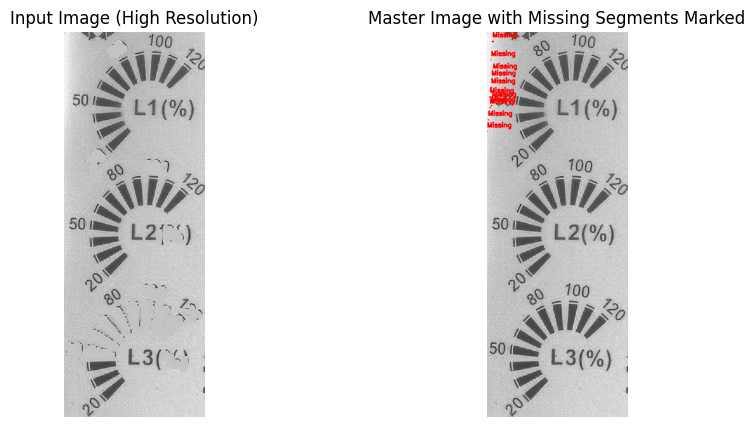

In [6]:
# Function to get the bounding boxes of the segments
def get_segment_bounding_boxes(contours):
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
    return bounding_boxes

input_bounding_boxes = get_segment_bounding_boxes(input_contours)
master_bounding_boxes = get_segment_bounding_boxes(master_contours)

# Define a tolerance for matching segment positions and sizes
position_tolerance = 20
size_tolerance = 0.14  # 15% size tolerance

# IoU calculation
def calculate_iou(boxA, boxB):
    xA, yA, wA, hA = boxA
    xB, yB, wB, hB = boxB
    x1A, y1A, x2A, y2A = xA, yA, xA + wA, yA + hA
    x1B, y1B, x2B, y2B = xB, yB, xB + wB, yB + hB
    inter_x1 = max(x1A, x1B)
    inter_y1 = max(y1A, y1B)
    inter_x2 = min(x2A, x2B)
    inter_y2 = min(y2A, y2B)
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    union_area = (wA * hA) + (wB * hB) - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Segment matching with IoU
def is_segment_present(master_box, input_boxes, position_tolerance, size_tolerance, iou_threshold=0.3):
    mx, my, mw, mh = master_box
    for ix, iy, iw, ih in input_boxes:
        if (abs(mx - ix) <= position_tolerance and
            abs(my - iy) <= position_tolerance and
            abs(mw - iw) / mw <= size_tolerance and
            abs(mh - ih) / mh <= size_tolerance):
            iou = calculate_iou(master_box, (ix, iy, iw, ih))
            if iou > iou_threshold:
                return True
    
    # If no matching segment was found, return False
    return False

# Check for missing segments
all_segments_present = True
for master_box, master_contour in zip(master_bounding_boxes, master_contours):
    if not is_segment_present(master_box, input_bounding_boxes, position_tolerance, size_tolerance):
        all_segments_present = False
        cv2.drawContours(master_image_hr, [master_contour], -1, (0, 0, 255), 2)
        cv2.putText(master_image_hr, "Missing", (master_box[0], master_box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Output Results
if all_segments_present:
    print("All segments in the master image are present in the input image.")
else:
    print("Some segments in the master image are missing in the input image.")

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image (High Resolution)")
plt.imshow(cv2.cvtColor(input_image_hr, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Master Image with Missing Segments Marked")
plt.imshow(cv2.cvtColor(master_image_hr, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

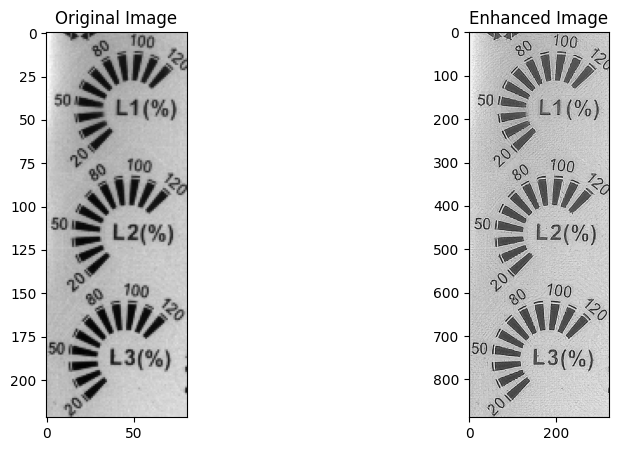

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

# Load the ESRGAN model
esrgan_model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

def apply_super_resolution(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Convert the image to a tensor
    image_tensor = tf.convert_to_tensor(image_rgb, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, 0)
    # Apply the ESRGAN model
    sr_image_tensor = esrgan_model(image_tensor)
    sr_image = tf.squeeze(sr_image_tensor).numpy()
    
    # Convert the image back to grayscale
    sr_image_gray = cv2.cvtColor(sr_image.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Apply additional sharpening
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened_image = cv2.filter2D(sr_image_gray, -1, kernel)
    
    return sharpened_image

# Example usage
image = cv2.imread('./Analog/train/class 1/good_11.png', cv2.IMREAD_GRAYSCALE)
enhanced_image = apply_super_resolution(image)

# Display the original and enhanced images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Enhanced Image')
plt.imshow(enhanced_image, cmap='gray')
plt.show()

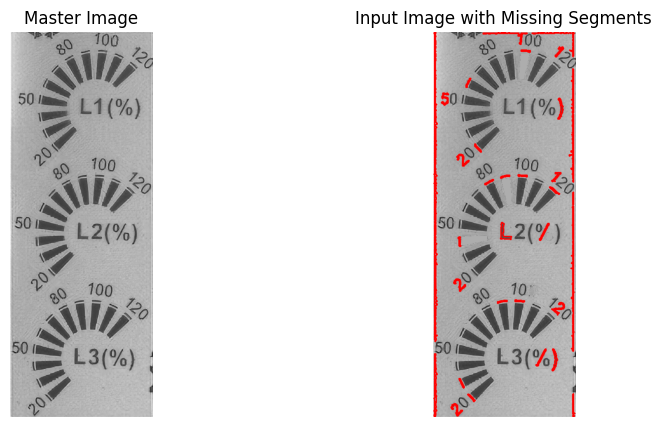

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image, blur_kernel=(5, 5)):
    """Preprocess the image by applying Gaussian blur and adaptive thresholding."""
    blurred = cv2.GaussianBlur(image, blur_kernel, 0)
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
    return thresh

def detect_segments(image):
    """Automatically detect segments using contours."""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    countours = [contour for contour in contours if cv2.contourArea(contour) > 50]
    return countours

def match_shapes(master_contours, input_contours, similarity_threshold=0.1):
    """Match shapes of contours from the master image to the input image."""
    missing_segments = []
    for master_contour in master_contours:
        matched = False
        for input_contour in input_contours:
            similarity = cv2.matchShapes(master_contour, input_contour, cv2.CONTOURS_MATCH_I1, 0.0)
            if similarity < similarity_threshold:
                matched = True
                break
        if not matched:
            missing_segments.append(master_contour)
    return missing_segments

# Load the master and input images
master_image_path = "./Analog_mobile/train/class 1/good_7.png"
input_image_path = "./Analog_mobile/train/class 0/bad_m_1.png"
master_image = cv2.imread(master_image_path, cv2.IMREAD_GRAYSCALE)
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the images
master_preprocessed = preprocess_image(master_image)
input_preprocessed = preprocess_image(input_image)

# Detect segments in the master and input images
master_contours = detect_segments(master_preprocessed)
input_contours = detect_segments(input_preprocessed)

# Match shapes of the contours
missing_segments = match_shapes(master_contours, input_contours)

# Visualize the results
output_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)
for contour in missing_segments:
    # Draw the contour for missing segments
    cv2.drawContours(output_image, [contour], -1, (0, 0, 255), 2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Master Image")
plt.imshow(cv2.cvtColor(master_image, cv2.COLOR_GRAY2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Input Image with Missing Segments")
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()